In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import utils as utils
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ipywidgets as widgets
import time
import math

## Present Value of Liabilities Calculation

- Assuming the discount rate is r

In [2]:
def discount(t, r):    
    """
    find the present value of a zero-coupon bond that returns a dollar at time 't'
    """
    return (1 + r)**(-t)

def pvl(l, r):
    """
    pvl computes the present values of multiple liabilities 
    l is a pandas series of liabilities: index=time, value=liability amount
    r is the discount rate
    """
    pv_ls = [discount(t, r)*l.loc[t] for t in l.index]
    pv_sum = sum(pv_ls)
    return pv_sum

def funding_ratio(assets, l, r):
    """
    assets are cash flows from assets
    l are cash flows from liabilities
    r is the discount rate
    """
    fr = pvl(assets, r)/pvl(l, r)
    return fr

## CIR Model to Simulate Changes in the Interest Rate and Liability Hedging

The Cox Ingersoll Ross model is used to model the dynamics of interest rates, and is an extension of the popular Vasicek Model to prevent negative interest rates

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dw_{t} $$

- b is the long term average interet rate
- $r_{t}$ is the interest rate at time t
- a determines how quickly r_t reverts to the mean
- $dw_{t}$ scaled by $\sigma$ is the volatilty factor 
- $\sqrt{r_{t}}$ is a factor to prevent negative interest rates from occurring - without it, we would have the Vasicek Model

- It's important to note that $r_{t}$ is the instantaneous rate (aka the short rate). The following formulas establish the relationship between the instantaneous interest rate and the annualized interest rate

$$1+r_{ann} = e^{r_{inst}}$$

In [3]:
# Functions convert annualized interest rates to instantaneous interest rates and vice versa

def ann_to_inst_rate(r_ann):
    r_inst = np.log(1 + r_ann)
    return r_inst

def inst_to_ann_rate(r_inst):
    r_ann = np.exp(r_inst) - 1
    return r_ann

$$ dr_{t}=a(b-r_{t})\,dt+\sigma {\sqrt {r_{t}}}\,dw_{t} $$


In [4]:
# this models the changes in the interest rate, assuming it can be modeled stochastically
def cir(n_years=10, n_scenarios=10, a=0.05, b=0.03, sigma=0.05, steps_per_year=12, r_0=None):
    
    if r_0 is None:
        r_0 = b

    # get the instantaneous interest rate
    r_0 = ann_to_inst_rate(r_0)

    dt = 1/steps_per_year
    num_steps = n_years*steps_per_year
    r_df = pd.DataFrame(index=range(num_steps+1), columns=range(n_scenarios), dtype=float)
    r_df.loc[0] = r_0

    # generate shocks 
    shocks = np.random.normal(loc=0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    
    # for generation of zero coupon bond prices
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = pd.DataFrame(index=range(num_steps+1), columns=range(n_scenarios), dtype=float)
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    
    prices.loc[0] = price(n_years, r_0)

    for t in range(num_steps):
        # extract interest rate at time 't'
        r_t = r_df.loc[t] 

        # generate random shock
        shock = shocks[t]

        # change in interest rate
        r_t_sqrt = r_t**0.5
        dr = a*(b - r_t)*dt + sigma*r_t_sqrt*shock

        # compute the interest rates at time 't+1' and fill in the dataframe
        r_t1 = abs(r_t + dr)
        r_df.loc[t+1] = r_t1
        
        # update the bond prices
        prices.loc[t+1] = price(n_years-(t+1)*dt, r_df.loc[t+1])
        
    return r_df, prices

# r_df, prices = cir(n_scenarios=20, sigma=0.01)
# r_df.plot.line(legend=False)
# plt.xlim(0)

## GHP Construction and Duration Matching

- Assume we don't have a zero coupon bond that has the maturity that we desire
- We can construct a portfolio of fixed income products that replicate liability matching

In [5]:
def bond_cash_flows(maturity, principal=1000, coupon_rate=0.03, coupons_per_year=12):
    num_coupons = round(maturity*coupons_per_year)
    coupon = principal*coupon_rate/coupons_per_year
    cf = np.repeat(coupon, num_coupons)
    cf[-1] += principal
    cf = pd.Series(cf, index=np.arange(1, num_coupons+1))
    return cf

def bond_price(maturity, principal=1000, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    cf = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    pv = pvl(cf, discount_rate/coupons_per_year)
    return pv

def mac_duration(cf, discount_rate):
    """
    Function computes the Macaulay Duration of the cash flows
    """
    discounts = discount(cf.index, discount_rate)
    weights = discounts * cf
    mac_d = (weights.index * weights).sum()/weights.sum()
    return mac_d

def match_duration(cf_t, cf_s, coup_period_t, coup_period_s, cf_l, discount_rate):
    """
    function generates allocation weight for the short bond, in order for duration matching
    """
    mac_d_t = mac_duration(cf_t, discount_rate/coup_period_t)/coup_period_t
    mac_d_s = mac_duration(cf_s, discount_rate/coup_period_s)/coup_period_s
    mac_d_l = mac_duration(cf_l, discount_rate)
    w = (mac_d_l - mac_d_t)/(mac_d_s - mac_d_t)
    return w

# add the cash flows 
def add_sb_lb_cf(sb_cf, lb_cf):
    p_flows = sb_cf + lb_cf
    for i in range(len(sb_cf)+1, len(lb_cf)+1):
        p_flows.loc[i] = lb_cf.loc[i]
    return p_flows

### Bond Price, Yield Relationship

<AxesSubplot:>

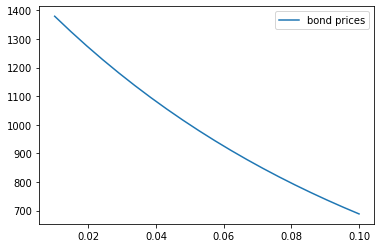

In [6]:
rates = np.linspace(0.01, 0.1, num=20)
bond_prices = [bond_price(10, 1000, 0.05, 2, dr) for dr in rates]
df = pd.DataFrame(bond_prices, index=rates, columns=["bond prices"])
df.plot.line()

### Demonstrate that match_duration weights generate assets, liabilities with same duration

In [7]:
l = pd.Series(data=[100000, 100000], index=[10, 12])
mac_d = mac_duration(l, 0.04)

sb_maturity = 10
lb_maturity = 20
short_bond_cf = bond_cash_flows(sb_maturity, 1000, 0.05, 1)
long_bond_cf = bond_cash_flows(lb_maturity, 1000, 0.05, 1)
w = match_duration(long_bond_cf, short_bond_cf, 1, 1, l, .04)
print("Macaulay Duration of Liabilities: " + str(mac_d))
print("Short Bond Allocation: " + str(w))

# determine how much of the short & long bond you can buy 
p_short_bond = bond_price(10, 1000, 0.05, 1, 0.04)
p_long_bond = bond_price(20, 1000, 0.05, 1, 0.04)

# starting capital 
a0 = 129000

# cash flows when investing a0 * w to the short bond 
sb_cf = (w*a0/p_short_bond) * short_bond_cf
lb_cf = ((1-w)*a0/p_long_bond) * long_bond_cf

# cash flows of sb and lb combined
p_flows = add_sb_lb_cf(sb_cf, lb_cf)
mac_d = mac_duration(p_flows, 0.04)
print("Macaulay Duration of Assets: " + str(mac_d))

Macaulay Duration of Liabilities: 10.960799385088393
Short Bond Allocation: 0.48263092069478974
Macaulay Duration of Assets: 10.960799385088391


In [8]:
def match_duration_cf(sb_maturity,
                      lb_maturity,
                      principal,
                      coupon_rate,
                      coupons_per_year,
                      l_cf,
                      discount_rate,
                      a0):
    
    """
    sb_maturity: maturity of short bond
    lb_maturity: maturity of long bond
    principal: face value of short bond and long bond
    coupon_rate: coupon = coupon_rate * principal
    coupons_per_year: # of coupons paid every year
    1_cf: cash flows of liabilities
    discount_rate: discount_rate
    a0: starting capital
    """
    
    # Macaulay Duration of liabilities
    mac_d = mac_duration(l, discount_rate)
#     print("Macaulay Duration of Liabilities: " + str(mac_d))

    # compute weight of short bond allocation that matches Macaulay Duration
    short_bond_cf = bond_cash_flows(sb_maturity, principal, coupon_rate, coupons_per_year)
    long_bond_cf = bond_cash_flows(lb_maturity, principal, coupon_rate, coupons_per_year)
    w = match_duration(long_bond_cf, short_bond_cf, l, discount_rate)
#     print("Short Bond Allocation: " + str(round(w, 4)))
    
    
    # determine how much of the short & long bond you can buy 
    p_short_bond = bond_price(sb_maturity, principal, coupon_rate, coupons_per_year, discount_rate)
    p_long_bond = bond_price(lb_maturity, principal, coupon_rate, coupons_per_year, discount_rate)
    num_short_bonds = w*a0/p_short_bond
    num_long_bonds = (1-w)*a0/p_long_bond
    
    # cash flows when investing a0 * w to the short bond 
    sb_cf = num_short_bonds * short_bond_cf
    lb_cf = num_long_bonds * long_bond_cf

    # cash flows of sb and lb combined
    p_flows = add_sb_lb_cf(sb_cf, lb_cf)
    mac_d = mac_duration(p_flows, 0.04)
#     print("Macaulay Duration of Assets: " + str(mac_d))
    
    return p_flows
    

### Demonstrate that the duration matched portfolio always has a funding ratio of 1

(0.0, 0.10500000000000001)

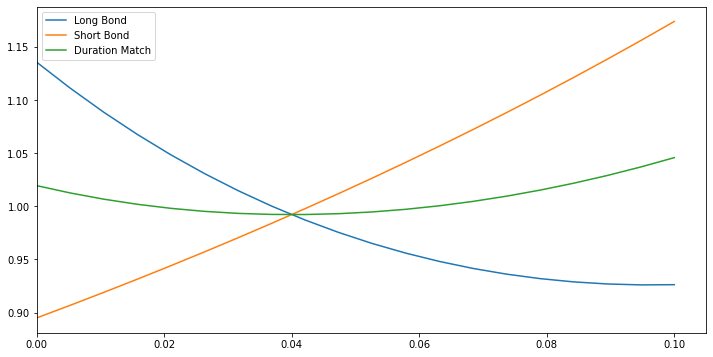

In [9]:
rates = np.linspace(0, 0.1, 20)

# funding ratio for 100% short bond portfolio
sb_asset_cf = (a0/p_short_bond) * short_bond_cf
lb_asset_cf = (a0/p_long_bond) * long_bond_cf

fr_short_bond_port = pd.Series([funding_ratio(sb_asset_cf, l, r) for r in rates])
fr_long_bond_port = pd.Series([funding_ratio(lb_asset_cf, l, r) for r in rates])
fr_dur_match_port = pd.Series([funding_ratio(p_flows, l, r) for r in rates])

fr_dur_match_port = pd.Series(fr_dur_match_port)
fr_df = pd.concat([fr_long_bond_port, fr_short_bond_port, fr_dur_match_port], axis=1)
fr_df.index = rates
fr_df.columns = ["Long Bond", "Short Bond", "Duration Match"]
fr_df.plot.line(figsize=(12, 6))
plt.xlim(0)

### Week4 Quiz

In [10]:
b1_p = bond_price(15, 1000, 0.05, 2, 0.05)
b2_p = bond_price(5, 1000, 0.06, 4, 0.05)
b3_p = bond_price(10, 1000, 0, 1, 0.05)

In [11]:
b1_cf = bond_cash_flows(15, 1000, 0.05, 2)
b2_cf = bond_cash_flows(5, 1000, 0.06, 4)
b3_cf = bond_cash_flows(10, 1000, 0, 1)

discount_rate = 0.05
b1_mac_d = mac_duration(b1_cf, discount_rate/2)
b2_mac_d = mac_duration(b2_cf, discount_rate/4)
b3_mac_d = mac_duration(b3_cf, discount_rate/1)

In [12]:
l = pd.Series(data=[100000, 200000, 300000], index=[3, 5, 10])
mac_d = mac_duration(l, 0.05)

short_bond_cf = bond_cash_flows(5, 1000, 0.06, 4)
long_bond_cf = bond_cash_flows(10, 1000, 0, 1)
w = match_duration(long_bond_cf, short_bond_cf, 1, 4, l, discount_rate)
print("Macaulay Duration of Liabilities: " + str(mac_d))
print("Short Bond Allocation: " + str(w))

Macaulay Duration of Liabilities: 6.75091785274465
Short Bond Allocation: 0.5774465770256699


In [13]:
mac_d_t = mac_duration(long_bond_cf, discount_rate/2)/2
mac_d_s = mac_duration(short_bond_cf, discount_rate/4)/4
mac_d_l = mac_duration(l, discount_rate)
w = (mac_d_l - mac_d_t)/(mac_d_s - mac_d_t)

mac_d_port = w * mac_d_s + (1-w) * mac_d_t
print("Liabiliy Macaulay Duration: " + str(mac_d_l))
print("Duration Matched Macaulay Duration: " + str(mac_d_port))

Liabiliy Macaulay Duration: 6.75091785274465
Duration Matched Macaulay Duration: 6.750917852744649
